<a href="https://colab.research.google.com/github/sjbaek12/sjbaek12.github.io/blob/master/%EC%A0%95%EC%B1%85%ED%95%99%EC%8A%B5_%EA%B8%B0%EB%B0%98_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

어떤 상태에서 특정한 액션을 취하면 리워드가 발생한다.
정책신경망에서 어떤 상태일때 액선이 산출되고 그 산출로 인한 리워드가 최대가 되도록 정책신경망의 가중치를 조정한다. 그러면 리워드가 최대가 되는 액션을 산출하는 정책신경망이 될 것이다. 

loss함수는 리워드가 최대가 되는 액션을 산출했을 때, 마이너스 무한대가 되도록 조정하면 된다. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

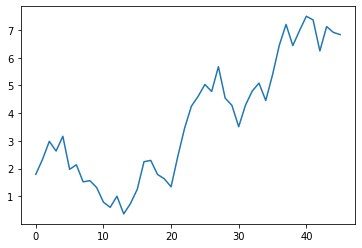

In [ ]:
# 환경 모듈

def env():
  start_price = 3
  pricej=[]
  for i in range(50):
    change = np.random.rand(1)*1.2
    direction = np.random.choice(2, p=[0.5, 0.5])
    if direction == 1:
      if start_price - change[0] <= 0:
         p = 1.0
      else:
         p = start_price - change[0]     
    else: 
      p = start_price + change[0] 
    start_price = p
    pricej.append(p)
#  p_mean = np.mean(price)
#  p_std = np.std(price)
#  price = (price - p_mean)/p_std
  
  p_serise= []
  for i in range(46):
    serise = [pricej[i],pricej[i+1], pricej[i+2], pricej[i+3], pricej[i+4]]
    serise = np.array(serise)
    p_serise.append(serise)
  p_serise= p_serise[0:50]
  p_serise = np.array(p_serise)
  p_serise_lstm = p_serise.reshape(46, 5, 1)  # p_serise의 길이는 46이다. LSTM을 사용할 때 데이터 input 형태
  price_lstm = pricej[4:]
  price_lstm = np.array(price_lstm)
  return p_serise, p_serise_lstm, price_lstm 

p_serise, p_serise_lstm, price_lstm = env()
plt.plot(price_lstm)
plt.show()

In [ ]:
price_data = [p_serise_lstm[j] for j in range(5)] 
price_data = np.array(price_data)
price_data.shape

(5, 5, 1)

In [ ]:
p_serise_lstm[0]

array([[3.70549417],
       [2.80407724],
       [2.45759833],
       [2.27523064],
       [3.10865426]])

이것은 Test이다. LSTM을 적용한 모델로 price 변동을 학습하는지 체크한다.
예측을 하는 것은 아니지만 주어진 데이터를 완벽하게 학습하고 재현한다.

In [ ]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)


import tensorflow as tf

import numpy as np

from tensorflow import keras
import keras.layers as layers
from keras.layers import Dense, LSTM,Input
from keras.models import Model
from keras.optimizers import Adam, RMSprop, SGD
import keras.backend as K 
from tensorflow.keras.utils import to_categorical
from keras.initializers import glorot_uniform



Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
def policy_model_lstm (lr):
  inp_L = layers.Input(shape=(5,1))  # 타입스텝수 5개, 특성개수 1개
  dense_L = LSTM(5)(inp_L)
  dense_L = Dense(64)(dense_L) 
  output_s = layers.Dense(1)(dense_L)

  model_train = Model(inputs=inp_L, outputs = output_s)
  model_train.compile(loss='mse', optimizer=Adam(lr), metrics = ['mae'])
  return model_train 

In [ ]:
model_train_test = policy_model_lstm(0.01)

In [ ]:
model_train_test.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 5)                 140       
_________________________________________________________________
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 589
Trainable params: 589
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_test = model_train_test.fit(p_serise_lstm, price_lstm, epochs=100, verbose=0)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
p_f = model_train_test.predict(p_serise_lstm)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


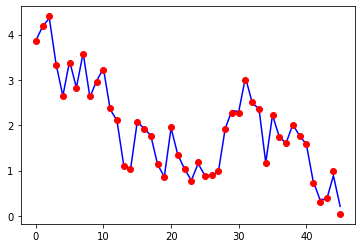

In [ ]:
plt.plot(p_f,"b")
plt.plot(price_lstm, 'ro')
plt.show()

여기부터 정책신경망 이다.

In [ ]:
class Agent(object):
  def __init__(self, ALPHA=0.01, GAMMA=0.99, n_actions=2, layer1_size=10, layer2_size=64, layer3_size=64, input_dims=4, fname='reinforce.h5'):
    self.gamma = GAMMA
    self.lr = ALPHA
    self.G = 0
    self.input_dims = input_dims
    self.fc1_dims = layer1_size
    self.fc2_dims = layer2_size
    self.fc3_dims = layer3_size
    self.n_actions = n_actions
    self.balance = [20, 0, 0]
    self.base_pv = 20
    self.target_ratio = 0.1
    self.state_memory = []
    self.action_memory = []
    self.reward_memory = []

    self.policy, self.predict = self.build_policy_network()
    self.action_space = [i for i in range(n_actions)]
    self.model_file = fname
     
  def build_policy_network(self):
    input=Input(shape=(5,1))
    advantages = Input(shape=[1])
    dense1 = LSTM(self.fc1_dims)(input)
    dense2 = Dense(self.fc2_dims)(dense1)
    dense3 = Dense(self.fc3_dims)(dense2)
    probs = Dense(self.n_actions, activation='softmax')(dense3)

    def custom_loss(y_true, y_pred):
      out = K.clip(y_pred, 1e-8, 1-1e-8)
      log_lik = K.sum(y_true*K.log(out), axis=1)*advantages
      return - log_lik
   
    policy = Model(inputs = [input, advantages], outputs = probs) # input = , output= 를 생략한 상태이다.
    policy.compile(optimizer = Adam(lr=self.lr), loss=custom_loss)
    predict = Model(inputs = input, outputs = probs) #input = , output= 를 생략한 상태이다.

    return policy, predict

  def choose_action(self, observation):
    state = observation[np.newaxis, :] # [1.0, 1.0]을 [[1.0, 1.0]]와 같이 한축을 추가한다.
    probabilities = self.predict.predict(state)[0]
    action = np.random.choice(self.action_space, p=probabilities)
    return action

  def validate_action(self, action, observation):
    price = observation[4]
    if action == 0:  # 0은 매수, 1은 보류, 2는 매도
      if self.balance[0] - price < 0:
        action_validated = 1
      else:
        action_validated = 0        
    if action == 1:
      if self.balance[2] > 0 :
        action_validated = 2
      else:
        action_validated = 1
    before_act_balance = [self.balance[0], self.balance[1], self.balance[2]] 

    return action_validated, before_act_balance  

  def balance_update(self, observation, action_validated):
    price = observation[4]
    if action_validated == 0:
      self.balance[0] = self.balance[0] - price
      self.balance[1] = price
      self.balance[2] = self.balance[2] + 1
    if action_validated == 1:
      self.balance[1] = price
    if action_validated == 2:
      self.balance[0] = self.balance[0] + price
      self.balance[1] = price
      self.balance[2] = self.balance[2] -1
    balance_updated = [self.balance[0], self.balance[1], self.balance[2]]
    present_value = self.balance[0] + self.balance[1] * self.balance[2]
    return balance_updated, present_value

  def pv_ratio(self, before_act_balance, balance_updated):
    pv_ratio = (balance_updated[0] + balance_updated[1] * balance_updated[2])/(before_act_balance[0] + before_act_balance[1] * before_act_balance[2])
    return pv_ratio

  def hold_ratio(self, balance_updated, observation, present_value):  # 주식보유 비율
    price = observation[4] 
    hold_ratio = balance_updated[2] / (present_value / price)
    return hold_ratio

  def base_pv_change (self, present_value):
    delay_ratio = (present_value - self.base_pv) / self.base_pv
    if delay_ratio > self.target_ratio:
      reward = 1
      self.base_pv = present_value
    elif (-1 * delay_ratio) > self.target_ratio:  #손실규모가 타켓을 상회할 때
      reward = -1
      self.base_pv = present_value
    else:
      reward = 0
      self.base_pv = self.base_pv
    return delay_ratio, reward 

  def store_transition(self, observation, action, reward):
    self.action_memory.append(action)
    self.state_memory.append(observation)
    self.reward_memory.append(reward)  


  def learn(self):
    state_memory = np.array(self.state_memory)
    action_memory = np.array(self.action_memory)
    reward_memory = np.array(self.reward_memory)

    y = np.zeros([len(action_memory), self.n_actions])
    y[np.arange(len(action_memory)), action_memory] = 1 # action memory 길이만큼 zero 리스트를 만들고, 각 리스트에 선택한 행동에 1을 넣어준다

    G= np.zeros_like(reward_memory)
    for t in range(len(reward_memory)):
      G_sum = 0
      discout = 1
      for k in range(t, len(reward_memory)):
        G_sum += reward_memory[k]*discout
        discout *= self.gamma

      G[t] = G_sum
    mean = np.mean(G)
    std = np.std(G) if np.std(G) > 0 else 1
    self.G = (G-mean)/std

    self.G = np.reshape(self.G, (len(reward_memory),1))

    history = self.policy.train_on_batch([state_memory, self.G], y)
     

  def reset_memory(self):
    self.state_memory= []
    self.action_memory = []
    self.reward_memory = []

  def reset_balance(self):
    self.balance = [20,0,0]
    self.base_pv = 20



In [ ]:
agent = Agent()

In [ ]:
observation = p_serise_lstm[0]

action = agent.choose_action(observation)
action_validated, before_act_balance = agent.validate_action(action, observation) 
balance_updated, present_value = agent.balance_update(observation, action_validated)
pv_ratio = agent.pv_ratio(before_act_balance, balance_updated)
hold_ratio = agent.hold_ratio(balance_updated, observation, present_value)
delay_ratio, reward = agent.base_pv_change(present_value)
agent.store_transition(observation, action, reward)
agent.learn()

print(action, action_validated, before_act_balance, balance_updated, present_value, pv_ratio, hold_ratio, delay_ratio, reward)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


[[1. 0.]]
0 0 [20, 0, 0] [array([15.56140324]), array([4.43859676]), 1] [20.] [1.] [0.22192984] [0.] 0


여기부터는 학습의 영역이다.

In [ ]:
# random action과 신경망의 선택 action을 조정해야 한다.


num_episode = 0.0
num_episodes = 100.0

agent = Agent()

while num_episode < num_episodes:

  action_history = []
  wealth_history = []
  agent.reset_balance()

  for i in range(len(p_serise_lstm)):
   
    observation = p_serise_lstm[i]

    action = agent.choose_action(observation)
    action_validated, before_act_balance = agent.validate_action(action, observation) 
    balance_updated, present_value = agent.balance_update(observation, action_validated)
    pv_ratio = agent.pv_ratio(before_act_balance, balance_updated)
    hold_ratio = agent.hold_ratio(balance_updated, observation, present_value)
    delay_ratio, reward = agent.base_pv_change(present_value)
    agent.store_transition(observation, action, reward)
    action_history.append(action)
    wealth_history.append(present_value)


    if (reward == 1): # reward == -1
      agent.learn()
      agent.reset_memory()
      continue

#  agent.learn()
#  agent.reset_memory()
  
  if (num_episode+1) % 20 == 0:
    print(wealth_history[-1])

  num_episode += 1.0
   

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


[26.67713744]
[20.07132881]
[62.75294271]
[69.32728265]
[18.8516224]


In [ ]:
[30.136815]
[15.7594771]
[20.81602087]
[20.554815]
[20.2495043]

[20.2495043]

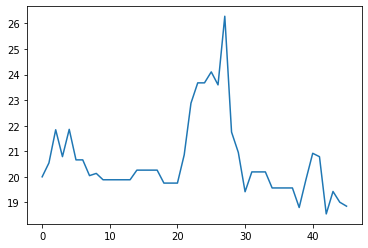

In [ ]:
plt.plot(wealth_history)
plt.show()

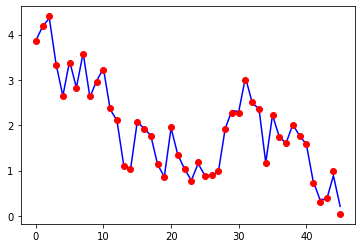

In [ ]:
plt.plot(p_f,"b")
plt.plot(price_lstm, 'ro')
plt.show()

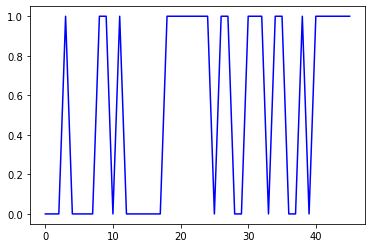

In [ ]:
plt.plot(action_history, 'b')
plt.show()

In [ ]:
# 학습을 위한 배치 데이터를 만든다.

def get_batch(transaction_history):


  for i in range(len(transaction_history)):

    if transaction_history[i][9] == 1:

      y = np.full((len(transaction_history), 2), 0.0) 
      for j in range(i+1):
        k = transaction_history[j][2] # k는 당초 신경망이 추천한 값으로 0구매, 1는 매도 이다. 
        y[j,k] = 1.0 # 신경망이 추천해 준 값을 1로 놓아, 0.0보다 높게 만든다. 이것은 각 행동에 대한 reword이자 action에 대한 추천확율이다.
      
      price_data = [p_serise_lstm[j] for j in range(i+1)]
      pv_ratios = [transaction_history[j][6] for j in range(i+1)]
      hold_ratios = [transaction_history[j][7] for j in range(i+1)]
      
      train_input =[]
      for pd, pr, hr in zip(price_data, pv_ratios, hold_ratios):
        pd = np.append(pd, pr)
        pd = np.append(pd, hr)
        train_input.append(pd)
      train_input = np.array(train_input)
      train_input = train_input.reshape(-1,7,1)

    elif transaction_history[i][9] == -1:
      
      y = np.full((len(transaction_history), 2), 1.0) 
      
      for j in range(i+1):
        k = transaction_history[j][2] # k는 당초 신경망이 추천한 값으로 0구매, 1는 매도 이다. 
        y[j,k] = 0.0 # 신경망이 추천해 준 값을 0로 놓아, 0.5보다 낮게 만든다. 반대 행동에 1.0의 보상을 주는 것과 같다.
      
      price_data = [p_serise_lstm[j] for j in range(i+1)]
      pv_ratios = [transaction_history[j][6] for j in range(i+1)]
      hold_ratios = [transaction_history[j][7] for j in range(i+1)]
      
      train_input =[]
      for pd, pr, hr in zip(price_data, pv_ratios, hold_ratios):
        pd = np.append(pd, pr)
        pd = np.append(pd, hr)
        train_input.append(pd)
      train_input = np.array(train_input)
      train_input = train_input.reshape(-1,7,1)

  return y, train_input






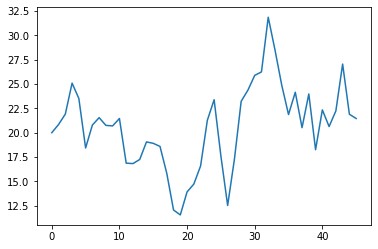

In [ ]:
plt.plot(wealth)
plt.show()

In [ ]:
# 거래와 관련된 모든 것을 기록한다.

def record(i, price, act, act_v, balance_updated, present_value, pv_ratio, hold_ratio, delay_ratio, target, base_pv):

  transaction_history.append([i, price, act, act_v, balance_updated, present_value, pv_ratio, hold_ratio, delay_ratio, target, base_pv])
  return transaction_history

In [ ]:
actions = []
for i in range(len(fkn)):
  actions.append(fkn[i][2])

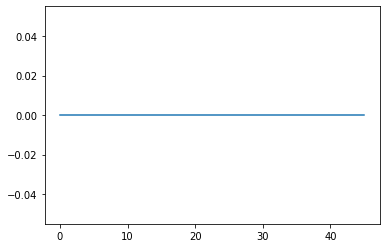

In [ ]:
plt.plot(actions)
plt.show()